# Single numpy file with spectrograms

There is room for tuning when producing the spectrograms: 
  - see influence of window shape and size: https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2_STFT-Window.html  
  - apply logarithm

To modify train/val/test sets, go to keras/03_stratified.ipynb

- Band pass applied before the SFFT: Not needed. Comparison applying band pass before with slicing the spectrogram without filtering.


**Table of contents**<a id='toc0_'></a>    
- [Definitions](#toc1_)    
- [Play building spectrograms](#toc2_)    
- [5 channels](#toc3_)    
- [Version v1](#toc4_)    
- [Reduced dataset](#toc5_)    
- [Checking output](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
# !pip install --upgrade scipy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import ShortTimeFFT, sosfiltfilt, butter
from scipy.signal.windows import gaussian

# base_dir = "../../kaggle_data/hms"
base_dir = "../../data/hms"
# base_dir = "/kaggle/input/hms-harmful-brain-activity-classification"

data_dir = '../data'
# data_dir = '/kaggle/input/hms-indices-train-val-test-v1'

output_dir = '../data/'
# output_dir = ''

fs = 200  # Sample rate.

df_traincsv = pd.read_csv(f'{base_dir}/train.csv')

TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

df_traincsv = pd.read_csv(f'{base_dir}/train.csv')
df_traincsv.loc[df_traincsv.expert_consensus == 'Seizure', 'target'] = 0
df_traincsv.loc[df_traincsv.expert_consensus == 'LPD', 'target'] = 1
df_traincsv.loc[df_traincsv.expert_consensus == 'GPD', 'target'] = 2
df_traincsv.loc[df_traincsv.expert_consensus == 'LRDA', 'target'] = 3
df_traincsv.loc[df_traincsv.expert_consensus == 'GRDA', 'target'] = 4
df_traincsv.loc[df_traincsv.expert_consensus == 'Other', 'target'] = 5

# Transform votes into percentages.
df_traincsv['sum_votes'] = df_traincsv.seizure_vote + df_traincsv.lpd_vote + df_traincsv.gpd_vote	+ df_traincsv.lrda_vote + df_traincsv.grda_vote + df_traincsv.other_vote
df_traincsv['seizure_vote'] = df_traincsv.seizure_vote/df_traincsv.sum_votes
df_traincsv['lpd_vote'] = df_traincsv.lpd_vote/df_traincsv.sum_votes
df_traincsv['gpd_vote'] = df_traincsv.gpd_vote/df_traincsv.sum_votes
df_traincsv['lrda_vote'] = df_traincsv.lrda_vote/df_traincsv.sum_votes
df_traincsv['grda_vote'] = df_traincsv.grda_vote/df_traincsv.sum_votes
df_traincsv['other_vote'] = df_traincsv.other_vote/df_traincsv.sum_votes

idxs_train = np.load(f'{data_dir}/03_stratified_v2_idxs_train.npy')
idxs_val = np.load(f'{data_dir}/03_stratified_v2_idxs_val.npy')
idxs_test = np.load(f'{data_dir}/03_stratified_v2_idxs_test.npy')
df_train = df_traincsv.loc[idxs_train]
df_val = df_traincsv.loc[idxs_val]
df_test = df_traincsv.loc[idxs_test]

print("Added target column. Transformed into percentages.")
print("Train:", len(df_train))
print("Val:", len(df_val))
print("Test:", len(df_test))


Added target column. Transformed into percentages.
Train: 12186
Val: 2148
Test: 1248


In [3]:
# Check there is no patient_id in more than one set.
ids = np.unique(df_train['patient_id'])
print(len(df_val.loc[df_val['patient_id'].isin(ids)]))
print(len(df_test.loc[df_test['patient_id'].isin(ids)]))
ids = np.unique(df_val['patient_id'])
print(len(df_train.loc[df_train['patient_id'].isin(ids)]))
print(len(df_test.loc[df_test['patient_id'].isin(ids)]))


2137
1243
6182
1220


## <a id='toc1_'></a>[Definitions](#toc0_)

In [6]:
# 2024022800
def banana(eeg_absolute, filter=False, fs=200.0):
    '''Returns pandas dataframe with a banana montage.

    filter: False or [low freq, high freq]
    '''
    if filter:
        filtered_data = eeg_absolute.copy()
        # Apply band pass.
        sos = butter(5, filter, btype='bandpass', fs=fs, output='sos')
        for c in filtered_data.columns:
            filtered_data[c] = sosfiltfilt(sos, filtered_data[c])
    else:
        filtered_data = eeg_absolute.copy()

    eeg = pd.DataFrame(data={
        'Fp1-F7' : filtered_data.Fp1 - filtered_data.F7,
        'Fp7-T3' : filtered_data.F7 - filtered_data.T3,
        'T3-T5' : filtered_data.T3 - filtered_data.T5,
        'T5-O1' : filtered_data.T5 - filtered_data.O1,

        'Fp2-F8' : filtered_data.Fp2 - filtered_data.F8,
        'F8-T4' : filtered_data.F8 - filtered_data.T4,
        'T4-T6' : filtered_data.T4 - filtered_data.T6,
        'T6-O2' : filtered_data.T6 - filtered_data.O2,

        'Fp1-F3' : filtered_data.Fp1 - filtered_data.F3,
        'F3-C3' : filtered_data.F3 - filtered_data.C3,
        'C3-P3' : filtered_data.C3 - filtered_data.P3,
        'P3-O1' : filtered_data.P3 - filtered_data.O1,

        'Fp2-F4' : filtered_data.Fp2 - filtered_data.F4,
        'F4-C4' : filtered_data.F4 - filtered_data.C4,
        'C4-P4' : filtered_data.C4 - filtered_data.P4,
        'P4-O2' : filtered_data.P4 - filtered_data.O2,

        'Fz-Cz' : filtered_data.Fz - filtered_data.Cz,
        'Cz-Pz' : filtered_data.Cz - filtered_data.Pz,

        'EKG' : filtered_data.EKG
        })
    return eeg

## <a id='toc2_'></a>[Play building spectrograms](#toc0_)

From banana montage.

In [12]:
# Grabs 50 second sub sample
# Interpolates (removes NaN) and builds banana montage.

eeg_id = 493696785
eeg_sub_id = 3  # seizure
item = df_traincsv.loc[(df_traincsv.eeg_id == eeg_id) & (df_traincsv.eeg_sub_id == eeg_sub_id)].iloc[0]
eeg_full = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')
# 50 second eeg sub sample
offset = int(item.eeg_label_offset_seconds)
start = offset * fs
end = (offset + 50) * fs
eeg_absolute = eeg_full[start:end]
eeg_absolute = eeg_absolute.interpolate(limit_direction='both') # <<<<< Interpolation
eeg = banana(eeg_absolute, filter=[1,70])
item

eeg_id                               493696785
eeg_sub_id                                   3
eeg_label_offset_seconds                  46.0
spectrogram_id                       458831369
spectrogram_sub_id                           3
spectrogram_label_offset_seconds          46.0
label_id                            1547083774
patient_id                               42180
expert_consensus                       Seizure
seizure_vote                               1.0
lpd_vote                                   0.0
gpd_vote                                   0.0
lrda_vote                                  0.0
grda_vote                                  0.0
other_vote                                 0.0
target                                     0.0
sum_votes                                    3
Name: 23571, dtype: object

In [14]:
# Pick the most representative series in each group.
# Groups: LL, RL, LP, RP, CC 

# Find negative correlation, pick one on the side of the flip.
# if no negative, then it's either one end.

In [40]:
# eeg_id = 722738444
# eeg_sub_id = 4


eeg_id = 2168453388
eeg_sub_id = 0


# eeg_id = 1327593077
# eeg_sub_id = 88

# eeg_id = 3988090520
# eeg_sub_id = 1

eeg = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')
# interpolate!
item = df_traincsv.loc[(df_traincsv.eeg_id == eeg_id) & (df_traincsv.eeg_sub_id == eeg_sub_id)].iloc[0]

# 10 second eeg sub samples 
offset = int(item.eeg_label_offset_seconds)
start = (offset + 20) * fs
end = (offset + 30) * fs
eeg_sub_10 = eeg[start:end]

(39, 682)


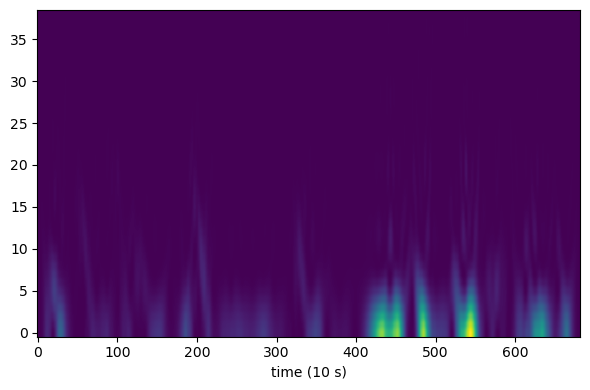

In [60]:
# Spectrogram of original eeg

N = eeg_sub_10.shape[0]
t_x = np.arange(N) * 1/fs  # time indexes for signal

g_std = 24  # standard deviation for Gaussian window in samples
hop = 3  # 8
win_width = 48  # Pick an odd number.  49
win = gaussian(win_width, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win, hop=hop, fs=fs, mfft=400)
electrode = 0
x = eeg_sub_10.iloc[:,electrode].values
Sx = SFT.spectrogram(x)  # calculate absolute square of STFT

# n = int(20/SFT.delta_f)  # Number of bins below 20 Hz.
# fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

n2 = int(20/SFT.delta_f)  # Number of bins below 30 Hz.
ax.imshow(Sx[1:n2,:], origin='lower', aspect='auto')
ax.set_xlabel('time (10 s)')

print(Sx[1:n2,:].shape)

plt.tight_layout()
plt.show()


## <a id='toc3_'></a>[5 channels](#toc0_)

One element of each group in the banana montage for each channel.

Find the most representative element in each group.

## <a id='toc4_'></a>[Version v1](#toc0_)

Deprecated.

Using only F3 and F4, in two channels.

In [7]:
#
# Training set
#

n_channels = 2
max_freq = 20  # Only keep freqs below this number.
# min_freq = 8  # Only keep freqs above this number.
# time_window = 10  # 10 second event.

#
# SFT setup: some tuning may be applied.
#
g_std = 24  # standard deviation for Gaussian window in samples
hop = 3
win_width = 48  # Pick an odd number.
mfft = 400
win = gaussian(win_width, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win, hop=hop, fs=fs, mfft=mfft)

n2 = int(max_freq/SFT.delta_f)  # Number of bins below max_freq (30 Hz).
# Dimensions of Sx, check the code in playing building spectrograms.
dim1 = 39
dim2 = 682
# Each channel is appended to all.
# all = np.array([]).reshape(0, dim1, dim2, n_channels)
specs = np.empty((len(df_train), dim1, dim2, n_channels))

# item: [eeg_id, eeg_sub_id, idx in all (1st index), target,
#       seizure_vote, lpd_vote, gpd_vote, lrda_vote,
#       grda_vote, other_vote]
items = np.array([], dtype=float).reshape(0,10)

for i in np.arange(len(df_train)):
    if i%400 == 0:
        print(f'{i} files loaded.', end='\r')
    item = df_train.iloc[i]
    eeg = pd.read_parquet(f'{base_dir}/train_eegs/{item.eeg_id}.parquet')
    eeg = eeg.interpolate(limit_direction='both') # <<<<< Interpolation

    # 10 second eeg sub samples 
    offset = int(item.eeg_label_offset_seconds)
    start = (offset + 20) * fs
    end = (offset + 30) * fs
    eeg_sub_10 = eeg[start:end]

    N = eeg_sub_10.shape[0]
    t_x = np.arange(N) * 1/fs  # time indexes for signal

    X = np.empty((1, dim1, dim2, n_channels))
    # X[0,:,:,c] = Sx[n1:n2,:].copy()

    # for c in np.arange(n_channels):
    x = eeg_sub_10['F3'].values
    Sx = SFT.spectrogram(x)  # calculate absolute square of STFT
    specs[i,:,:,0] = Sx[1:n2,:].copy()
    x = eeg_sub_10['F4'].values
    Sx = SFT.spectrogram(x)  # calculate absolute square of STFT
    specs[i,:,:,1] = Sx[1:n2,:].copy()

    xitem = np.array([item.eeg_id, item.eeg_sub_id, i, item.target,
                    item.seizure_vote, item.lpd_vote, item.gpd_vote,
                    item.lrda_vote, item.grda_vote, item.other_vote],
                    dtype=float).reshape(1,10)
    items = np.concatenate([items, xitem])

filename = '03_single_spectrograms_v1_train'     
print(f'Saving to {filename}.npy')
print(f'Saving to {filename}_items.npy')
np.save(f'{output_dir}{filename}.npy', specs)
np.save(f'{output_dir}{filename}_items.npy', items)


KeyboardInterrupt: 

In [8]:
#
# Validation set
#

n_channels = 2
max_freq = 20  # Only keep freqs below this number.
# min_freq = 8  # Only keep freqs above this number.
# time_window = 10  # 10 second event.

#
# SFT setup: some tuning may be applied.
#
g_std = 24  # standard deviation for Gaussian window in samples
hop = 3
win_width = 48  # Pick an odd number.
mfft = 400
win = gaussian(win_width, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win, hop=hop, fs=fs, mfft=mfft)

n2 = int(max_freq/SFT.delta_f)  # Number of bins below max_freq (30 Hz).
# Dimensions of Sx, check the code in playing building spectrograms.
dim1 = 39
dim2 = 682
# Each channel is appended to all.
# all = np.array([]).reshape(0, dim1, dim2, n_channels)
specs = np.empty((len(df_val), dim1, dim2, n_channels))

# item: [eeg_id, eeg_sub_id, idx in all (1st index), target,
#       seizure_vote, lpd_vote, gpd_vote, lrda_vote,
#       grda_vote, other_vote]
items = np.array([], dtype=float).reshape(0,10)

for i in np.arange(len(df_val)):
    if i%400 == 0:
        print(f'{i} files loaded.', end='\r')
    item = df_val.iloc[i]
    eeg = pd.read_parquet(f'{base_dir}/train_eegs/{item.eeg_id}.parquet')
    eeg = eeg.interpolate(limit_direction='both') # <<<<< Interpolation

    # 10 second eeg sub samples 
    offset = int(item.eeg_label_offset_seconds)
    start = (offset + 20) * fs
    end = (offset + 30) * fs
    eeg_sub_10 = eeg[start:end]

    N = eeg_sub_10.shape[0]
    t_x = np.arange(N) * 1/fs  # time indexes for signal

    X = np.empty((1, dim1, dim2, n_channels))
    # X[0,:,:,c] = Sx[n1:n2,:].copy()

    # for c in np.arange(n_channels):
    x = eeg_sub_10['F3'].values
    Sx = SFT.spectrogram(x)  # calculate absolute square of STFT
    specs[i,:,:,0] = Sx[1:n2,:].copy()
    x = eeg_sub_10['F4'].values
    Sx = SFT.spectrogram(x)  # calculate absolute square of STFT
    specs[i,:,:,1] = Sx[1:n2,:].copy()

    xitem = np.array([item.eeg_id, item.eeg_sub_id, i, item.target,
                    item.seizure_vote, item.lpd_vote, item.gpd_vote,
                    item.lrda_vote, item.grda_vote, item.other_vote],
                    dtype=float).reshape(1,10)
    items = np.concatenate([items, xitem])

filename = '03_single_spectrograms_v1_val'     
print(f'Saving to {filename}.npy')
print(f'Saving to {filename}_items.npy')
np.save(f'{output_dir}{filename}.npy', specs)
np.save(f'{output_dir}{filename}_items.npy', items)

Saving to 03_single_spectrograms_v1_val.npy
Saving to 03_single_spectrograms_v1_val_items.npy


In [9]:
#
# Testing set
#

n_channels = 2
max_freq = 20  # Only keep freqs below this number.
# min_freq = 8  # Only keep freqs above this number.
# time_window = 10  # 10 second event.

#
# SFT setup: some tuning may be applied.
#
g_std = 24  # standard deviation for Gaussian window in samples
hop = 3
win_width = 48  # Pick an odd number.
mfft = 400
win = gaussian(win_width, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win, hop=hop, fs=fs, mfft=mfft)

n2 = int(max_freq/SFT.delta_f)  # Number of bins below max_freq (30 Hz).
# Dimensions of Sx, check the code in playing building spectrograms.
dim1 = 39
dim2 = 682
# Each channel is appended to all.
# all = np.array([]).reshape(0, dim1, dim2, n_channels)
specs = np.empty((len(df_test), dim1, dim2, n_channels))

# item: [eeg_id, eeg_sub_id, idx in all (1st index), target,
#       seizure_vote, lpd_vote, gpd_vote, lrda_vote,
#       grda_vote, other_vote]
items = np.array([], dtype=float).reshape(0,10)

for i in np.arange(len(df_test)):
    if i%400 == 0:
        print(f'{i} files loaded.', end='\r')
    item = df_test.iloc[i]
    eeg = pd.read_parquet(f'{base_dir}/train_eegs/{item.eeg_id}.parquet')
    eeg = eeg.interpolate(limit_direction='both') # <<<<< Interpolation

    # 10 second eeg sub samples 
    offset = int(item.eeg_label_offset_seconds)
    start = (offset + 20) * fs
    end = (offset + 30) * fs
    eeg_sub_10 = eeg[start:end]

    N = eeg_sub_10.shape[0]
    t_x = np.arange(N) * 1/fs  # time indexes for signal

    X = np.empty((1, dim1, dim2, n_channels))
    # X[0,:,:,c] = Sx[n1:n2,:].copy()

    # for c in np.arange(n_channels):
    x = eeg_sub_10['F3'].values
    Sx = SFT.spectrogram(x)  # calculate absolute square of STFT
    specs[i,:,:,0] = Sx[1:n2,:].copy()
    x = eeg_sub_10['F4'].values
    Sx = SFT.spectrogram(x)  # calculate absolute square of STFT
    specs[i,:,:,1] = Sx[1:n2,:].copy()

    xitem = np.array([item.eeg_id, item.eeg_sub_id, i, item.target,
                    item.seizure_vote, item.lpd_vote, item.gpd_vote,
                    item.lrda_vote, item.grda_vote, item.other_vote],
                    dtype=float).reshape(1,10)
    items = np.concatenate([items, xitem])

filename = '03_single_spectrograms_v1_test'     
print(f'Saving to {filename}.npy')
print(f'Saving to {filename}_items.npy')
np.save(f'{output_dir}{filename}.npy', specs)
np.save(f'{output_dir}{filename}_items.npy', items)

Saving to 03_single_spectrograms_v1_test.npy
Saving to 03_single_spectrograms_v1_test_items.npy


## <a id='toc5_'></a>[Reduced dataset](#toc0_)

In [3]:
df_train_reduced = df_train.sample(400)
df_val_reduced = df_val.sample(100)
df_test_reduced = df_test.sample(100)

#
# Training set
#

n_channels = 2
max_freq = 20  # Only keep freqs below this number.
# min_freq = 8  # Only keep freqs above this number.
# time_window = 10  # 10 second event.

#
# SFT setup: some tuning may be applied.
#
g_std = 24  # standard deviation for Gaussian window in samples
hop = 3
win_width = 48  # Pick an odd number.
mfft = 400
win = gaussian(win_width, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win, hop=hop, fs=fs, mfft=mfft)

n2 = int(max_freq/SFT.delta_f)  # Number of bins below max_freq (30 Hz).
# Dimensions of Sx, check the code in playing building spectrograms.
dim1 = 39
dim2 = 682
# Each channel is appended to all.
# all = np.array([]).reshape(0, dim1, dim2, n_channels)
specs = np.empty((len(df_train_reduced), dim1, dim2, n_channels))

# item: [eeg_id, eeg_sub_id, idx in all (1st index), target,
#       seizure_vote, lpd_vote, gpd_vote, lrda_vote,
#       grda_vote, other_vote]
items = np.array([], dtype=float).reshape(0,10)

for i in np.arange(len(df_train_reduced)):
    if i%100 == 0:
        print(f'{i} files loaded.', end='\r')
    item = df_train_reduced.iloc[i]
    eeg = pd.read_parquet(f'{base_dir}/train_eegs/{item.eeg_id}.parquet')
    eeg = eeg.interpolate(limit_direction='both') # <<<<< Interpolation

    # 10 second eeg sub samples 
    offset = int(item.eeg_label_offset_seconds)
    start = (offset + 20) * fs
    end = (offset + 30) * fs
    eeg_sub_10 = eeg[start:end]

    N = eeg_sub_10.shape[0]
    t_x = np.arange(N) * 1/fs  # time indexes for signal

    X = np.empty((1, dim1, dim2, n_channels))
    # X[0,:,:,c] = Sx[n1:n2,:].copy()

    # for c in np.arange(n_channels):
    x = eeg_sub_10['F3'].values
    Sx = SFT.spectrogram(x)  # calculate absolute square of STFT
    specs[i,:,:,0] = Sx[1:n2,:].copy()
    x = eeg_sub_10['F4'].values
    Sx = SFT.spectrogram(x)  # calculate absolute square of STFT
    specs[i,:,:,1] = Sx[1:n2,:].copy()

    xitem = np.array([item.eeg_id, item.eeg_sub_id, i, item.target,
                    item.seizure_vote, item.lpd_vote, item.gpd_vote,
                    item.lrda_vote, item.grda_vote, item.other_vote],
                    dtype=float).reshape(1,10)
    items = np.concatenate([items, xitem])

filename = '03_single_spectrograms_reduced_v1_train'     
print(f'Saving to {filename}.npy')
print(f'Saving to {filename}_items.npy')
np.save(f'{output_dir}{filename}.npy', specs)
np.save(f'{output_dir}{filename}_items.npy', items)

#
# Validation set
#

n_channels = 2
max_freq = 20  # Only keep freqs below this number.
# min_freq = 8  # Only keep freqs above this number.
# time_window = 10  # 10 second event.

#
# SFT setup: some tuning may be applied.
#
g_std = 24  # standard deviation for Gaussian window in samples
hop = 3
win_width = 48  # Pick an odd number.
mfft = 400
win = gaussian(win_width, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win, hop=hop, fs=fs, mfft=mfft)

n2 = int(max_freq/SFT.delta_f)  # Number of bins below max_freq (30 Hz).
# Dimensions of Sx, check the code in playing building spectrograms.
dim1 = 39
dim2 = 682
# Each channel is appended to all.
# all = np.array([]).reshape(0, dim1, dim2, n_channels)
specs = np.empty((len(df_val_reduced), dim1, dim2, n_channels))

# item: [eeg_id, eeg_sub_id, idx in all (1st index), target,
#       seizure_vote, lpd_vote, gpd_vote, lrda_vote,
#       grda_vote, other_vote]
items = np.array([], dtype=float).reshape(0,10)

for i in np.arange(len(df_val_reduced)):
    if i%100 == 0:
        print(f'{i} files loaded.', end='\r')
    item = df_val_reduced.iloc[i]
    eeg = pd.read_parquet(f'{base_dir}/train_eegs/{item.eeg_id}.parquet')
    eeg = eeg.interpolate(limit_direction='both') # <<<<< Interpolation

    # 10 second eeg sub samples 
    offset = int(item.eeg_label_offset_seconds)
    start = (offset + 20) * fs
    end = (offset + 30) * fs
    eeg_sub_10 = eeg[start:end]

    N = eeg_sub_10.shape[0]
    t_x = np.arange(N) * 1/fs  # time indexes for signal

    X = np.empty((1, dim1, dim2, n_channels))
    # X[0,:,:,c] = Sx[n1:n2,:].copy()

    # for c in np.arange(n_channels):
    x = eeg_sub_10['F3'].values
    Sx = SFT.spectrogram(x)  # calculate absolute square of STFT
    specs[i,:,:,0] = Sx[1:n2,:].copy()
    x = eeg_sub_10['F4'].values
    Sx = SFT.spectrogram(x)  # calculate absolute square of STFT
    specs[i,:,:,1] = Sx[1:n2,:].copy()

    xitem = np.array([item.eeg_id, item.eeg_sub_id, i, item.target,
                    item.seizure_vote, item.lpd_vote, item.gpd_vote,
                    item.lrda_vote, item.grda_vote, item.other_vote],
                    dtype=float).reshape(1,10)
    items = np.concatenate([items, xitem])

filename = '03_single_spectrograms_reduced_v1_val'     
print(f'Saving to {filename}.npy')
print(f'Saving to {filename}_items.npy')
np.save(f'{output_dir}{filename}.npy', specs)
np.save(f'{output_dir}{filename}_items.npy', items)

#
# Testing set
#

n_channels = 2
max_freq = 20  # Only keep freqs below this number.
# min_freq = 8  # Only keep freqs above this number.
# time_window = 10  # 10 second event.

#
# SFT setup: some tuning may be applied.
#
g_std = 24  # standard deviation for Gaussian window in samples
hop = 3
win_width = 48  # Pick an odd number.
mfft = 400
win = gaussian(win_width, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win, hop=hop, fs=fs, mfft=mfft)

n2 = int(max_freq/SFT.delta_f)  # Number of bins below max_freq (30 Hz).
# Dimensions of Sx, check the code in playing building spectrograms.
dim1 = 39
dim2 = 682
# Each channel is appended to all.
# all = np.array([]).reshape(0, dim1, dim2, n_channels)
specs = np.empty((len(df_test_reduced), dim1, dim2, n_channels))

# item: [eeg_id, eeg_sub_id, idx in all (1st index), target,
#       seizure_vote, lpd_vote, gpd_vote, lrda_vote,
#       grda_vote, other_vote]
items = np.array([], dtype=float).reshape(0,10)

for i in np.arange(len(df_test_reduced)):
    if i%400 == 0:
        print(f'{i} files loaded.', end='\r')
    item = df_test_reduced.iloc[i]
    eeg = pd.read_parquet(f'{base_dir}/train_eegs/{item.eeg_id}.parquet')
    eeg = eeg.interpolate(limit_direction='both') # <<<<< Interpolation

    # 10 second eeg sub samples 
    offset = int(item.eeg_label_offset_seconds)
    start = (offset + 20) * fs
    end = (offset + 30) * fs
    eeg_sub_10 = eeg[start:end]

    N = eeg_sub_10.shape[0]
    t_x = np.arange(N) * 1/fs  # time indexes for signal

    X = np.empty((1, dim1, dim2, n_channels))
    # X[0,:,:,c] = Sx[n1:n2,:].copy()

    # for c in np.arange(n_channels):
    x = eeg_sub_10['F3'].values
    Sx = SFT.spectrogram(x)  # calculate absolute square of STFT
    specs[i,:,:,0] = Sx[1:n2,:].copy()
    x = eeg_sub_10['F4'].values
    Sx = SFT.spectrogram(x)  # calculate absolute square of STFT
    specs[i,:,:,1] = Sx[1:n2,:].copy()

    xitem = np.array([item.eeg_id, item.eeg_sub_id, i, item.target,
                    item.seizure_vote, item.lpd_vote, item.gpd_vote,
                    item.lrda_vote, item.grda_vote, item.other_vote],
                    dtype=float).reshape(1,10)
    items = np.concatenate([items, xitem])

filename = '03_single_spectrograms_reduced_v1_test'     
print(f'Saving to {filename}.npy')
print(f'Saving to {filename}_items.npy')
np.save(f'{output_dir}{filename}.npy', specs)
np.save(f'{output_dir}{filename}_items.npy', items)


Saving to 03_single_spectrograms_reduced_v1_train.npy
Saving to 03_single_spectrograms_reduced_v1_train_items.npy
Saving to 03_single_spectrograms_reduced_v1_val.npy
Saving to 03_single_spectrograms_reduced_v1_val_items.npy
Saving to 03_single_spectrograms_reduced_v1_test.npy
Saving to 03_single_spectrograms_reduced_v1_test_items.npy


## <a id='toc6_'></a>[Checking output](#toc0_)

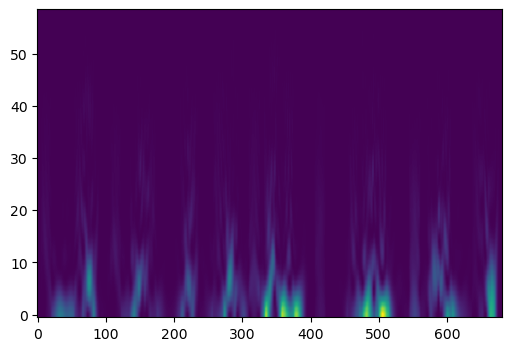

In [57]:
# Is this figure the same as the one produced in
# build_spectrograms/01_eeg_spectrogram.ipynb?

fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit

ax1.imshow(specs[44,:,:,0], origin='lower', aspect='auto')
# ax1.imshow(Sx[:n2,:], origin='lower', aspect='auto')

plt.show()


# eeg.shape